#Tasks
Conduct EDA on your dataset(s)

Summarize the dataset, including the target variable, features, and types of data

Identify and handle missing, duplicate, or inconsistent data

Calculate measures like mean, median, standard deviation, and correlations

Create insightful visualizations (e.g., histograms, scatter plots, heatmaps)

Generate preliminary insights or questions to guide future analysis (hypothesis formation)


#1. Summarize the dataest:#

The main dataset we will be using contains police call record from San Jose, CA, decumenting details about various incidents, locations and how they were handled.

Key Columns:


* OFFENSE_DATE - Date of the reported incident
* OFFENSE_TIME - Time of the reported incident
* PRIORITY - Urgency level(lower number indicate higher prioity)
* CALL_TYPE - Descript of the incident
* FINAL_DISPO - Final disposition(outcome)
* ADDRESS - Approximate location
* CITY - San Jose
* STATE - CA





In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
import re

In [2]:
github_dataset = 'https://raw.githubusercontent.com/truongng1/crime_trends_sj/refs/heads/main/datasets/'
df_2013 = pd.read_csv(github_dataset + '/911cals/policecalls2013.csv', sep  = ',')
df_2014 = pd.read_csv(github_dataset + '/911cals/policecalls2014.csv', sep  = ',')
df_2015 = pd.read_csv(github_dataset + '/911cals/policecalls2015.csv', sep  = ',')
df_2016 = pd.read_csv(github_dataset + '/911cals/policecalls2016.csv', sep  = ',')
df_2017 = pd.read_csv(github_dataset + '/911cals/policecalls2017.csv', sep  = ',')
df_2018 = pd.read_csv(github_dataset + '/911cals/policecalls2018.csv', sep  = ',')
df_2019 = pd.read_csv(github_dataset + '/911cals/policecalls2019.csv', sep  = ',')
df_2020 = pd.read_csv(github_dataset + '/911cals/policecalls2020.csv', sep  = ',')
df_2021 = pd.read_csv(github_dataset + '/911cals/policecalls2021.csv', sep  = ',')
df_2022 = pd.read_csv(github_dataset + '/911cals/policecalls2022.csv', sep  = ',')
df_2023 = pd.read_csv(github_dataset + '/911cals/policecalls2023.csv', sep  = ',')
df_2024 = pd.read_csv(github_dataset + '/911cals/policecalls2024.csv', sep  = ',')

In [8]:
frames = [df_2013, df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024]
df = pd.concat(frames)

In [9]:
useless_columns = ['CDTS', 'EID', 'START_DATE', 'CALL_NUMBER', 'REPORT_DATE', 'CALLTYPE_CODE']
df = df.drop(columns = useless_columns)
df['OFFENSE_DATE'] = pd.to_datetime(df['OFFENSE_DATE'])
df.head()

/var/folders/ms/398w_1k10rx6t73mkc4vb3740000gn/T/ipykernel_93493/2983688761.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['OFFENSE_DATE'] = pd.to_datetime(df['OFFENSE_DATE'], errors = 'coerce')


,PRIORITY,OFFENSE_DATE,OFFENSE_TIME,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE
0,4,2013-01-01,00:00:06,"DISTURBANCE, FIRECRACKERS",NR,No Response,UTOPIA PL & PEAK DR,San Jose,CA
1,4,2013-01-01,00:01:05,MEET THE CITIZEN,G,Gone on Arrival/unable to loca,QUIMBY RD & S WHITE RD,San Jose,CA
2,2,2013-01-01,00:02:01,FIREARMS DISCHARGED,NR,No Response,[3500]-[3600] PAYNE AV,San Jose,CA
3,2,2013-01-01,00:02:43,FIREARMS DISCHARGED,NR,No Response,[800]-[900] SAKURA DR,San Jose,CA
4,4,2013-01-01,00:02:49,"DISTURBANCE, FIRECRACKERS",CAN,Canceled,VINEYARD DR & SANTA TERESA BL,San Jose,CA


In [11]:
mean_priorit_per_year = df.groupby(df['OFFENSE_DATE'].dt.year)['PRIORITY'].mean()
print(mean_priorit_per_year)

OFFENSE_DATE
2013    3.271296
2014    3.242663
2015    3.198577
2016    3.163708
2017    3.200130
2018    3.335573
2019    3.351204
2020    3.217372
2021    3.295503
2022    3.326116
2023    3.181171
2024    3.213218
Name: PRIORITY, dtype: float64


#4. Create insightful visualizations (e.g., histograms, scatter plots, heatmaps)


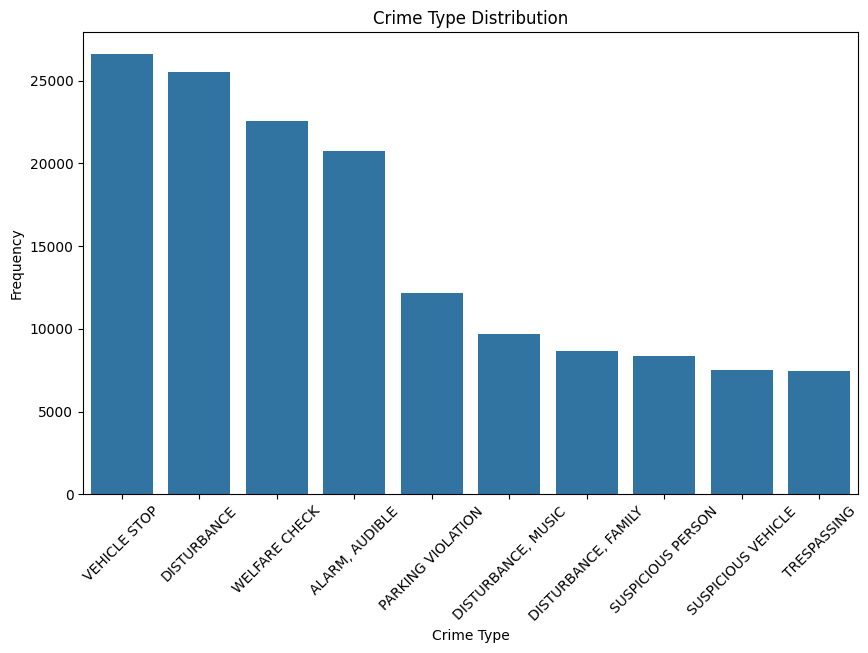

In [ ]:
crime_counts = update_df['CALL_TYPE'].value_counts()
top_10_crimes = crime_counts.head(10)


plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_crimes.index, y=top_10_crimes.values)
plt.xticks(rotation=45)
plt.title('Crime Type Distribution')
plt.xlabel('Crime Type')
plt.ylabel('Frequency')
plt.show()

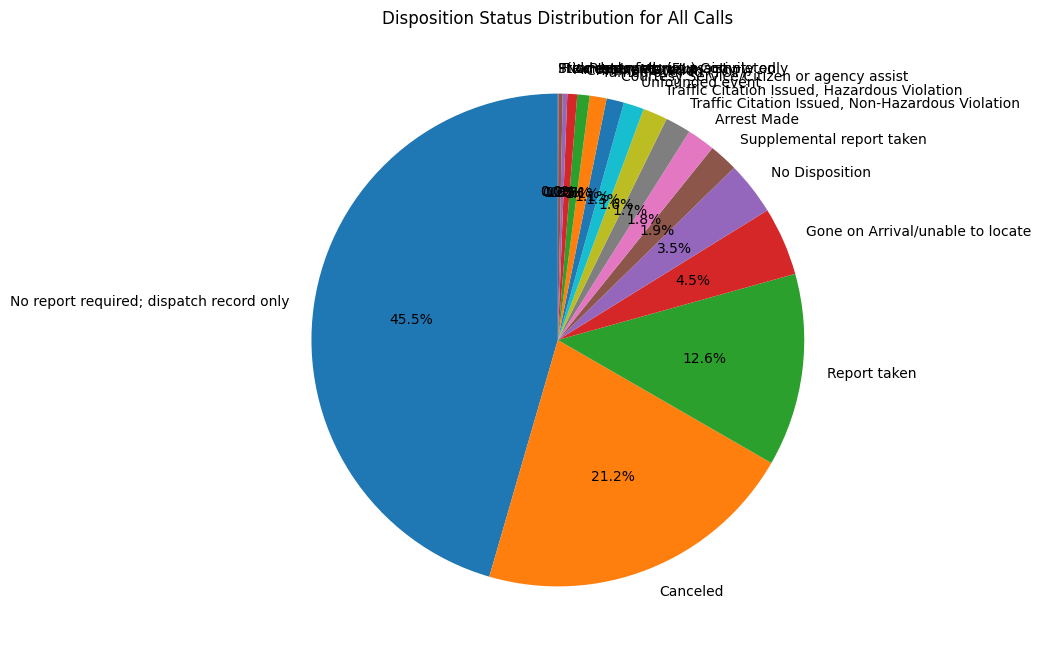

In [ ]:
disposition_counts = df['FINAL_DISPO'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(disposition_counts, labels=disposition_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Disposition Status Distribution for All Calls')

plt.show()

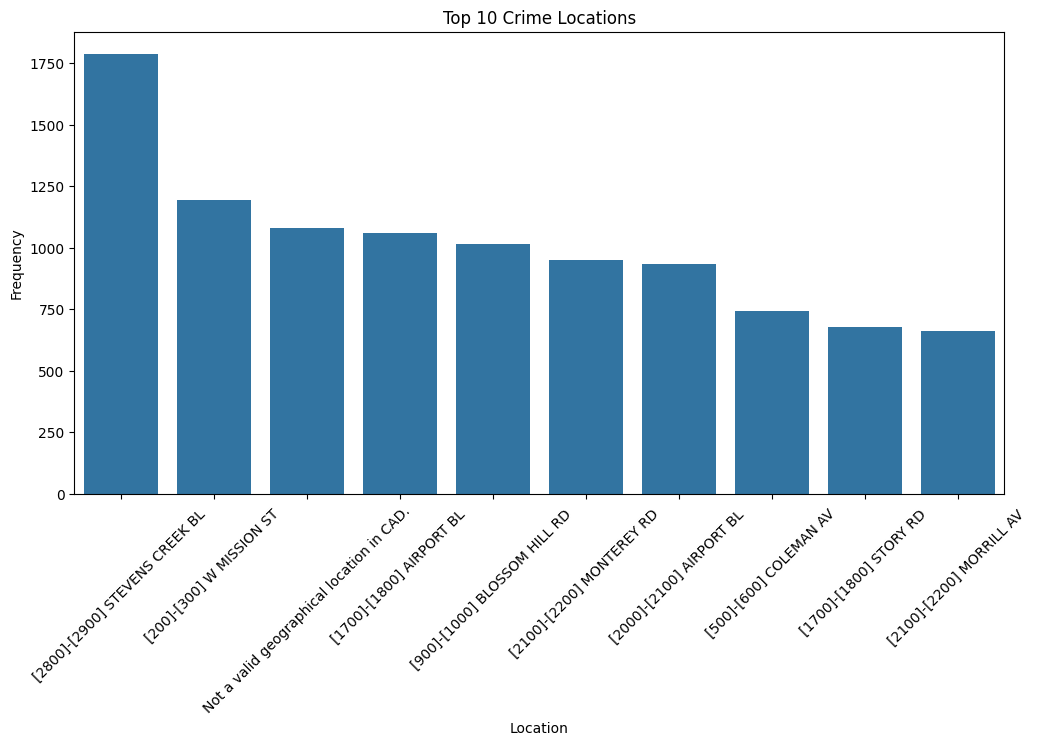

ADDRESS
[2800]-[2900] STEVENS CREEK BL               1788
[200]-[300] W MISSION ST                     1194
Not a valid geographical location in CAD.    1082
[1700]-[1800] AIRPORT BL                     1060
[900]-[1000] BLOSSOM HILL RD                 1016
[2100]-[2200] MONTEREY RD                     949
[2000]-[2100] AIRPORT BL                      933
[500]-[600] COLEMAN AV                        742
[1700]-[1800] STORY RD                        677
[2100]-[2200] MORRILL AV                      660
Name: count, dtype: int64


In [ ]:
location_counts = df['ADDRESS'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=location_counts.index, y=location_counts.values)
plt.xticks(rotation=45)
plt.title('Top 10 Crime Locations')
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.show()

print(location_counts)

## Eric Trial Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
github_dataset = 'https://raw.githubusercontent.com/truongng1/crime_trends_sj/refs/heads/main/datasets/'
df_2013 = pd.read_csv(github_dataset + '/911cals/policecalls2013.csv', sep  = ',')
df_2014 = pd.read_csv(github_dataset + '/911cals/policecalls2014.csv', sep  = ',')
df_2015 = pd.read_csv(github_dataset + '/911cals/policecalls2015.csv', sep  = ',')
df_2016 = pd.read_csv(github_dataset + '/911cals/policecalls2016.csv', sep  = ',')
df_2017 = pd.read_csv(github_dataset + '/911cals/policecalls2017.csv', sep  = ',')
df_2018 = pd.read_csv(github_dataset + '/911cals/policecalls2018.csv', sep  = ',')
df_2019 = pd.read_csv(github_dataset + '/911cals/policecalls2019.csv', sep  = ',')
df_2020 = pd.read_csv(github_dataset + '/911cals/policecalls2020.csv', sep  = ',')
df_2021 = pd.read_csv(github_dataset + '/911cals/policecalls2021.csv', sep  = ',')
df_2022 = pd.read_csv(github_dataset + '/911cals/policecalls2022.csv', sep  = ',')
df_2023 = pd.read_csv(github_dataset + '/911cals/policecalls2023.csv', sep  = ',')
df_2024 = pd.read_csv(github_dataset + '/911cals/policecalls2024.csv', sep  = ',')

In [ ]:
df_2013.head()

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE
0,20130101000052PS,4684476,5/13/2021 12:00:00 AM,P123660873,4,1/1/2013 12:00:00 AM,1/1/2013 12:00:00 AM,00:00:06,415FC,"DISTURBANCE, FIRECRACKERS",NR,No Response,UTOPIA PL & PEAK DR,San Jose,CA
1,20130101032822PS,4684484,5/13/2021 12:00:00 AM,P130010002,4,1/1/2013 12:00:00 AM,1/1/2013 12:00:00 AM,00:01:05,1062,MEET THE CITIZEN,G,Gone on Arrival/unable to loca,QUIMBY RD & S WHITE RD,San Jose,CA
2,20130101002612PS,4684485,5/13/2021 12:00:00 AM,P130010003,2,1/1/2013 12:00:00 AM,1/1/2013 12:00:00 AM,00:02:01,1057,FIREARMS DISCHARGED,NR,No Response,[3500]-[3600] PAYNE AV,San Jose,CA
3,20130101000624PS,4684486,5/13/2021 12:00:00 AM,P130010004,2,1/1/2013 12:00:00 AM,1/1/2013 12:00:00 AM,00:02:43,1057,FIREARMS DISCHARGED,NR,No Response,[800]-[900] SAKURA DR,San Jose,CA
4,20130101000303PS,4684487,5/13/2021 12:00:00 AM,P130010005,4,1/1/2013 12:00:00 AM,1/1/2013 12:00:00 AM,00:02:49,415FC,"DISTURBANCE, FIRECRACKERS",CAN,Canceled,VINEYARD DR & SANTA TERESA BL,San Jose,CA


In [ ]:
frames = [df_2013, df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023, df_2024]

In [ ]:
result = pd.concat(frames)

In [ ]:
result

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE
0,20130101000052PS,4684476,5/13/2021 12:00:00 AM,P123660873,4,1/1/2013 12:00:00 AM,1/1/2013 12:00:00 AM,00:00:06,415FC,"DISTURBANCE, FIRECRACKERS",NR,No Response,UTOPIA PL & PEAK DR,San Jose,CA
1,20130101032822PS,4684484,5/13/2021 12:00:00 AM,P130010002,4,1/1/2013 12:00:00 AM,1/1/2013 12:00:00 AM,00:01:05,1062,MEET THE CITIZEN,G,Gone on Arrival/unable to loca,QUIMBY RD & S WHITE RD,San Jose,CA
2,20130101002612PS,4684485,5/13/2021 12:00:00 AM,P130010003,2,1/1/2013 12:00:00 AM,1/1/2013 12:00:00 AM,00:02:01,1057,FIREARMS DISCHARGED,NR,No Response,[3500]-[3600] PAYNE AV,San Jose,CA
3,20130101000624PS,4684486,5/13/2021 12:00:00 AM,P130010004,2,1/1/2013 12:00:00 AM,1/1/2013 12:00:00 AM,00:02:43,1057,FIREARMS DISCHARGED,NR,No Response,[800]-[900] SAKURA DR,San Jose,CA
4,20130101000303PS,4684487,5/13/2021 12:00:00 AM,P130010005,4,1/1/2013 12:00:00 AM,1/1/2013 12:00:00 AM,00:02:49,415FC,"DISTURBANCE, FIRECRACKERS",CAN,Canceled,VINEYARD DR & SANTA TERESA BL,San Jose,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276064,20250101023534PS,10305810,12/31/2024 12:00:00 AM,P243660883,3,12/31/2024 12:00:00 AM,12/31/2024 12:00:00 AM,23:48:36,1033A,"ALARM, AUDIBLE",U,Unfounded event,[4100]-[4200] MONTEREY RD,San Jose,CA
276065,20241231235336PS,10305811,12/31/2024 12:00:00 AM,P243660884,2,12/31/2024 12:00:00 AM,12/31/2024 12:00:00 AM,23:48:40,415,DISTURBANCE,CAN,Canceled,[1700]-[1800] TULLY RD,San Jose,CA
276066,20250101010534PS,10305812,12/31/2024 12:00:00 AM,P243660885,4,12/31/2024 12:00:00 AM,12/31/2024 12:00:00 AM,23:50:27,415M,"DISTURBANCE, MUSIC",CAN,Canceled,[1100]-[1200] ROYAL CREST DR,San Jose,CA
276067,20250101002143PS,10305813,12/31/2024 12:00:00 AM,P243660886,3,12/31/2024 12:00:00 AM,12/31/2024 12:00:00 AM,23:57:51,415F,"DISTURBANCE, FAMILY",N,No report required; dispatch record only,[2700]-[2800] STORY RD,San Jose,CA


In [ ]:
result = result.drop(['CDTS', 'EID', 'START_DATE', 'CALL_NUMBER','REPORT_DATE'], axis = 1)

In [ ]:
result

,PRIORITY,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE
0,4,1/1/2013 12:00:00 AM,00:00:06,415FC,"DISTURBANCE, FIRECRACKERS",NR,No Response,UTOPIA PL & PEAK DR,San Jose,CA
1,4,1/1/2013 12:00:00 AM,00:01:05,1062,MEET THE CITIZEN,G,Gone on Arrival/unable to loca,QUIMBY RD & S WHITE RD,San Jose,CA
2,2,1/1/2013 12:00:00 AM,00:02:01,1057,FIREARMS DISCHARGED,NR,No Response,[3500]-[3600] PAYNE AV,San Jose,CA
3,2,1/1/2013 12:00:00 AM,00:02:43,1057,FIREARMS DISCHARGED,NR,No Response,[800]-[900] SAKURA DR,San Jose,CA
4,4,1/1/2013 12:00:00 AM,00:02:49,415FC,"DISTURBANCE, FIRECRACKERS",CAN,Canceled,VINEYARD DR & SANTA TERESA BL,San Jose,CA
...,...,...,...,...,...,...,...,...,...,...
276064,3,12/31/2024 12:00:00 AM,23:48:36,1033A,"ALARM, AUDIBLE",U,Unfounded event,[4100]-[4200] MONTEREY RD,San Jose,CA
276065,2,12/31/2024 12:00:00 AM,23:48:40,415,DISTURBANCE,CAN,Canceled,[1700]-[1800] TULLY RD,San Jose,CA
276066,4,12/31/2024 12:00:00 AM,23:50:27,415M,"DISTURBANCE, MUSIC",CAN,Canceled,[1100]-[1200] ROYAL CREST DR,San Jose,CA
276067,3,12/31/2024 12:00:00 AM,23:57:51,415F,"DISTURBANCE, FAMILY",N,No report required; dispatch record only,[2700]-[2800] STORY RD,San Jose,CA


In [ ]:
result['CALL_TYPE'].unique()

array(['DISTURBANCE, FIRECRACKERS', 'MEET THE CITIZEN',
       'FIREARMS DISCHARGED', 'DISTURBANCE, FAMILY', 'DRUNK IN PUBLIC',
       'ALARM, AUDIBLE', 'MENTALLY DISTURBED PERSON', 'MISSING FEMALE',
       'ALARM, SILENT', 'MISDEMEANOR HIT AND RUN', 'RECKLESS DRIVING',
       'DISTURBANCE, MUSIC', 'ALARM', 'UNK TYPE 911 CALL FROM CELL',
       'MISDEMEANOR DUI', 'SUSPICIOUS CIRCUMSTANCES',
       'DISTURBANCE, FIGHT', 'STOLEN VEHICLE',
       'VEHICLE ACCIDENT, PROPERTY DAM', 'DISTURBANCE',
       'SUSPICIOUS VEHICLE', 'SUSPICIOUS PERSON',
       'FEMALE CALLING FOR HELP', 'PROWLER', 'DISTURBANCE, UNKNOWN',
       'BATTERY', 'PARKING VIOLATION', 'VEHICLE STOP', 'PEDESTRIAN STOP',
       'TRAFFIC HAZARD', 'VEHICLE ACCIDENT, AMB DISPATCH',
       'DEFRAUDING AN INKEEPER', 'WELFARE CHECK', 'PERSON DOWN',
       'TRESPASSING', 'THEFT', 'MALICIOUS MISCHIEF',
       'SHOOTING INTO OCCP VEH OR DWEL', 'THROWING SUBSTANCES AT VEHICLE',
       'RECOVERED STOLEN VEHICLE', 'PERSON STABBED',
     

In [ ]:
call_type_mapping = {
    'Violent Crimes': ['MURDER', 'ASSAULT', 'ASSAULT WITH DEADLY WEAPON', 'ASSAULT WITH DEADLY WEAPON, GANG', 'ASSAULT ON AN OFFICER', 'BATTERY', 'BATTERY ON AN OFFICER', 'BATTERY ON A PEACE OFFICER', 'BATTERY, SERIOUS INJURY', 'BATTERY, GANG RELATED', 'PERSON STABBED', 'PERSON SHOT', 'SHOOTING INTO OCCP VEH OR DWELLING', 'CRIMINAL THREATS', 'KIDNAPPING', 'FALSE IMPRISONMENT', 'CHILD ABUSE', 'CHILD BEATING', 'ELDER/DEPENDENT ADULT ABUSE', 'DOMESTIC VIOLENCE', 'STALKING', 'HATE CRIMES'],
    'Property Crimes': ['THEFT', 'PETTY THEFT', 'GRAND THEFT', 'PURSE SNATCH ROBBERY', 'THEFT OF RECYCLABLES', 'THEFT, GANG RELATED', 'BURGLARY (460)', 'BURGLARY REPORT (460)', 'VEHICLE BURGLARY', 'ROBBERY', 'ARMED ROBBERY', 'ARMED ROBBERY, GANG RELATED', 'STRONG ARM ROBBERY', 'CARJACKING', 'STOLEN VEHICLE', 'STOLEN VEHICLE, GANG RELATED', 'RECOVERED STOLEN VEHICLE', 'RECEIVE/POSSESS STOLEN PROP', 'MALICIOUS MISCHIEF', 'MALICIOUS MISCHIEF, GANG RELATED', 'ARSON (447A)', 'TAMPERING WITH A VEHICLE', 'FORGERY', 'EMBEZZLEMENT', 'DEFRAUDING AN INNKEEPER', 'EXTORTION', 'EXTORTION, GANG RELATED'],
    'Weapons Related': ['FIREARMS DISCHARGED', 'BRANDISHING A WEAPON', 'BRANDISHING A WEAPON, GANG', 'CARRYING A CONCEALED WEAPON', 'ILLEGAL WEAPONS', 'ILLEGAL WEAPONS, GANG RELATED', 'DISTURBANCE, WEAPON', 'SUSPICIOUS PERSON W/ WEAPON'],
    'Public Disturbances': ['DISTURBANCE', 'DISTURBANCE, FAMILY', 'DISTURBANCE, FIGHT', 'DISTURBANCE, MUSIC', 'DISTURBANCE, NEIGHBOR', 'DISTURBANCE, UNKNOWN', 'DISTURBANCE, JUVENILE', 'DISTURBANCE, GANG', 'DISTURBANCE, JUVENILE GANG', 'DISTURBANCE, MOTORCYCLE', 'DISTURBANCE, FIRECRACKERS', 'THROWING SUBSTANCES AT VEHICLE', 'INDECENT EXPOSURE', 'OBSCENE OR HARASSING PH CALLS', 'NOISY ANIMAL'],
    'Substance Offenses': ['DRUNK IN PUBLIC', 'INTOXICATED PERSON', 'MISDEMEANOR DUI', 'FELONY DUI', 'POSSESSION OF MARIJUANA', 'POSSESSION OF NARCOTICS', 'POSSESSION OF NARCOTICS, GANG RELATED', 'POSSESSION OF CONTROLLED SUBSTANCE', 'POSSESSION OF CONTROLLED SUBSTANCE, GANG RELATED', 'USE OF CONTROLLED SUBSTANCE', 'NARCOTICS', 'NARCOTICS, GANG RELATED', 'SELL OR FURN ALCOHOL TO MINOR', 'MINOR IN POSSESSION OF ALCOHOL'],
    'Traffic and Vehicle Incidents': ['RECKLESS DRIVING', 'SPEEDING', 'SPEED CONTEST', 'MISDEMEANOR HIT AND RUN', 'FELONY HIT AND RUN', 'DRIVING W/SUSPENDED LICENSE', 'DRIVING W/SUS LIC-VEH IMPOUNDED', 'UNLICENSED DRIVER', 'VEHICLE ACCIDENT, PROPERTY DAMAGE', 'VEHICLE ACCIDENT, MINOR INJURIES', 'VEHICLE ACCIDENT, MAJOR INJURIES', 'VEHICLE ACCIDENT, UNKNOWN INJURIES', 'VEHICLE ACCIDENT, AMB DISPATCHED', 'TRAFFIC HAZARD', 'TRAFFIC CONTROL', 'VEHICLE STOP', 'PEDESTRIAN STOP', 'ABANDONED VEHICLE', 'SUSPICIOUS VEHICLE', 'PARKING VIOLATION', 'HANDICAPPED PARKING VIOLATION', 'EXPIRED REGISTRATION', 'ALTERED VIN NUMBER', 'JOYRIDING'],
    'Suspicious Activity': ['SUSPICIOUS PERSON', 'SUSPICIOUS FEMALE', 'SUSPICIOUS PERSON (GANG)', 'SUSPICIOUS CIRCUMSTANCES', 'SUSPICIOUS PACKAGE', 'PROWLER', 'OPEN DOOR', 'OPEN WINDOW'],
    'Public Safety': ['WELFARE CHECK', 'PERSON DOWN', 'SICK PERSON', 'INJURED PERSON', 'INJURED ANIMAL', 'MENTALLY DISTURBED PERSON', 'MENTALLY DISTURBED FEMALE', 'MISSING PERSON', 'MISSING FEMALE', 'MISSING JUVENILE', 'MISSING FEMALE JUVENILE', 'MISSING PERSON, MENTAL HANDICAP', 'FOUND, MISSING PERSON', 'FEMALE CALLING FOR HELP', 'PERSON CALLING FOR HELP', 'FIRE (SPECIFY TYPE)', 'EXPLOSION', 'BOMB THREAT', 'CORONERS CASE', 'PUBLIC SAFETY ASSISTANCE', 'FIRE DEPARTMENT REQUEST FOR PD'],
    'Juvenile and Minor Incidents': ['TRUANT (TABS)', 'W&I-UNDER JURIS OF JUV COURT', 'W&I UNCONTROLLABLE JUVENILE', 'JUVENILE VIOLATING COURT ORDER', 'MOLEST/ANNOY UNDER 18YRS'],
    'Miscellaneous Crimes and Violations': ['TRESPASSING', 'RESISTING ARREST', 'RESISTING ARREST, GANG RELATED', 'VIOLATION OF PROTECTIVE ORDER', 'PAROLE VIOLATION', 'SOLICITING FOR PROSTITUTION', 'SOLICITING FOR LEWD CONDUCT', 'BAD CHECKS', 'VAGRANT', 'CRUELTY TO ANIMALS', 'VICIOUS ANIMAL', 'ANIMAL COMPLAINT', 'DEAD ANIMAL', 'STRAY HORSE', 'GARBAGE COMPLAINT', 'CIVIL MATTER', 'OBSTRUCT STREETS OR SIDEWALK', 'REFUSAL TO LEAVE PROPERTY'],
    'Alarms and 911 Calls': ['ALARM', 'ALARM, AUDIBLE', 'ALARM, SILENT', 'ALARM, SVRN', 'UNK TYPE 911 CALL', 'UNK TYPE 911 CALL FROM CELL', 'UNK TYPE 911 CALL FROM RESD', 'UNK TYPE 911 CALL FROM BUSN', 'UNK TYPE 911 CALL FROM PAYPHON', 'UNK TYPE 911 CALL FROM VOIP TE', '911 CALL FROM AIRBORNE AIRCRAFT'],
    'Community Policing': ['COMMUNITY POLICING OFFICE', 'COMMUNITY POLICING SCHOOL', 'COMMUNITY POLICING MEETING', 'COMMUNITY POLICING -CITZ ASSIST', 'MEET THE CITIZEN', 'TAKE A REPORT', 'FOUND PROPERTY', 'REGISTRATION OF SEX OFFENDER']
}

In [ ]:
def categorize_call_type(call_type):
    for category, types in call_type_mapping.items():
        if call_type in types:
            return category
    return 'OTHER'

result['CALL_TYPE_clean'] = result['CALL_TYPE'].apply(lambda x: categorize_call_type(str(x)))

In [ ]:
result['CALL_TYPE_clean'].unique()

array(['Public Disturbances', 'Community Policing', 'Weapons Related',
       'Substance Offenses', 'Alarms and 911 Calls', 'Public Safety',
       'Traffic and Vehicle Incidents', 'Suspicious Activity',
       'Property Crimes', 'OTHER', 'Violent Crimes',
       'Miscellaneous Crimes and Violations',
       'Juvenile and Minor Incidents'], dtype=object)